# MIssing modalities

In this notebook, we investigate how AVIB behaves, when certain modalities are missing.
We train on the alpha+beta set (peptide+CDR3b+CDR3a), and test removing CDR3a or CDR3b.

In [1]:
import pandas as pd
import torch
import numpy as np
import random
import os

from vibtcr.dataset import TCRDataset
from vibtcr.mvib.mvib import MVIB
from vibtcr.mvib.mvib_trainer import TrainerMVIB

from torch.utils.data.sampler import WeightedRandomSampler
from torch.autograd import Variable

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, auc
import pandas as pd
import torch

metrics = [
    'AUROC',
    'Accuracy',
    'F1',
    'AUPR'
]

def pr_auc(y_true, y_prob):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall, precision)
    return pr_auc

def get_scores(y_true, y_prob, y_pred):
    """
    Compute a df with all classification metrics and respective scores.
    """
    
    scores = [
        roc_auc_score(y_true, y_prob),
        accuracy_score(y_true, y_pred),
        f1_score(y_true, y_pred),
        pr_auc(y_true, y_prob)
    ]
    
    df = pd.DataFrame(data={'score': scores, 'metrics': metrics})
    return df

In [3]:
def set_random_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)

In [4]:
import os
login = os.getlogin( )
DATA_BASE = f"/home/{login}/Git/tcr/data/"
RESULTS_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/results/"
FIGURES_BASE = f"/home/{login}/Git/tcr/notebooks/notebooks.classification/figures/"
# To run in github checkout of vibtcr, after `unzip data.zip` ...
DATA_BASE = os.path.join('..', '..', 'data')
RESULTS_BASE = os.path.join('.', 'results')
FIGURES_BASE = os.path.join('.', 'figures')

In [5]:
device = torch.device('cuda:0')

batch_size = 4096
epochs = 500
lr = 1e-3

z_dim = 150
early_stopper_patience = 50
monitor = 'auROC'
lr_scheduler_param = 10
joint_posterior = "aoe"

beta = 1e-6

# AVIB -  alpha+beta set - peptide+CDR3b+CDR3a

In [6]:
df = pd.read_csv(os.path.join(DATA_BASE, 'alpha-beta-splits', 'alpha-beta.csv'))

for i in range(5):  # 5 independent train/test splits
    set_random_seed(i)

    df_train, df_test = train_test_split(df.copy(), test_size=0.2, random_state=i)
    scaler = TCRDataset(df_train.copy(), torch.device("cpu"), cdr3b_col='tcrb', cdr3a_col='tcra').scaler

    ds_test = TCRDataset(df_test, torch.device("cpu"), cdr3b_col='tcrb', cdr3a_col='tcra', scaler=scaler)

    df_train, df_val = train_test_split(df_train, test_size=0.2, stratify=df_train.sign, random_state=i)
        
    # train loader with balanced sampling
    ds_train = TCRDataset(df_train, device, cdr3b_col='tcrb', cdr3a_col='tcra', scaler=scaler)
    class_count = np.array([df_train[df_train.sign == 0].shape[0], df_train[df_train.sign == 1].shape[0]])
    weight = 1. / class_count
    samples_weight = torch.tensor([weight[s] for s in df_train.sign])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    train_loader = torch.utils.data.DataLoader(
        ds_train,
        batch_size=batch_size,
        sampler=sampler
    )
    
    # val loader with balanced sampling
    ds_val = TCRDataset(df_val, device, cdr3b_col='tcrb', cdr3a_col='tcra', scaler=scaler)
    class_count = np.array([df_val[df_val.sign == 0].shape[0], df_val[df_val.sign == 1].shape[0]])
    weight = 1. / class_count
    samples_weight = torch.tensor([weight[s] for s in df_val.sign])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    val_loader = torch.utils.data.DataLoader(
        ds_val,
        batch_size=batch_size,
        sampler=sampler
    )

    model = MVIB(z_dim=z_dim, device=device, joint_posterior=joint_posterior).to(device)

    trainer = TrainerMVIB(
        model,
        epochs=epochs,
        lr=lr,
        beta=beta,
        checkpoint_dir=".",
        mode="trimodal",
        lr_scheduler_param=lr_scheduler_param
    )
    checkpoint = trainer.train(train_loader, val_loader, early_stopper_patience, monitor)    
    
    # test - missing beta
    model = MVIB.from_checkpoint(checkpoint, torch.device("cpu"))
    pred = model.classify(pep=ds_test.pep, cdr3b=None, cdr3a=ds_test.cdr3a)
    pred = pred.detach().numpy()
    df_test['prediction_'+str(i)] = pred.squeeze().tolist()

    # save results for further analysis
    df_test.to_csv(
        os.path.join(RESULTS_BASE, f"mvib.missing-b.{joint_posterior}.rep-{i}.csv"),
        index=False
    )
    
    # test - missing alpha
    model = MVIB.from_checkpoint(checkpoint, torch.device("cpu"))
    pred = model.classify(pep=ds_test.pep, cdr3b=ds_test.cdr3b, cdr3a=None)
    pred = pred.detach().numpy()
    df_test['prediction_'+str(i)] = pred.squeeze().tolist()

    # save results for further analysis
    df_test.to_csv(
        os.path.join(RESULTS_BASE, f"mvib.missing-a.{joint_posterior}.rep-{i}.csv"),
        index=False
    )

[VAL] Best epoch 67 | Best val score -0.936078 | DKL-prior 0.000515 | BCE 0.554967 | auROC 0.9361:  23%|██▎       | 116/500 [17:35<58:14,  9.10s/it]
[VAL] Best epoch 87 | Best val score -0.938097 | DKL-prior 0.000471 | BCE 0.763757 | auROC 0.9381:  27%|██▋       | 136/500 [20:48<55:40,  9.18s/it]
[VAL] Best epoch 66 | Best val score -0.941041 | DKL-prior 0.000509 | BCE 0.498802 | auROC 0.9410:  23%|██▎       | 115/500 [17:38<59:03,  9.20s/it]
[VAL] Best epoch 86 | Best val score -0.940587 | DKL-prior 0.000469 | BCE 0.593260 | auROC 0.9406:  27%|██▋       | 135/500 [20:34<55:37,  9.14s/it]
[VAL] Best epoch 91 | Best val score -0.943080 | DKL-prior 0.000442 | BCE 0.606285 | auROC 0.9431:  28%|██▊       | 140/500 [21:26<55:08,  9.19s/it]


# MVIB -  alpha+beta set - peptide+CDR3b+CDR3a

In [7]:
joint_posterior = "poe"

In [8]:
df = pd.read_csv(os.path.join(DATA_BASE, 'alpha-beta-splits', 'alpha-beta.csv'))

for i in range(5):  # 5 independent train/test splits
    set_random_seed(i)

    df_train, df_test = train_test_split(df.copy(), test_size=0.2, random_state=i)
    scaler = TCRDataset(df_train.copy(), torch.device("cpu"), cdr3b_col='tcrb', cdr3a_col='tcra').scaler

    ds_test = TCRDataset(df_test, torch.device("cpu"), cdr3b_col='tcrb', cdr3a_col='tcra', scaler=scaler)

    df_train, df_val = train_test_split(df_train, test_size=0.2, stratify=df_train.sign, random_state=i)
        
    # train loader with balanced sampling
    ds_train = TCRDataset(df_train, device, cdr3b_col='tcrb', cdr3a_col='tcra', scaler=scaler)
    class_count = np.array([df_train[df_train.sign == 0].shape[0], df_train[df_train.sign == 1].shape[0]])
    weight = 1. / class_count
    samples_weight = torch.tensor([weight[s] for s in df_train.sign])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    train_loader = torch.utils.data.DataLoader(
        ds_train,
        batch_size=batch_size,
        sampler=sampler
    )
    
    # val loader with balanced sampling
    ds_val = TCRDataset(df_val, device, cdr3b_col='tcrb', cdr3a_col='tcra', scaler=scaler)
    class_count = np.array([df_val[df_val.sign == 0].shape[0], df_val[df_val.sign == 1].shape[0]])
    weight = 1. / class_count
    samples_weight = torch.tensor([weight[s] for s in df_val.sign])
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    val_loader = torch.utils.data.DataLoader(
        ds_val,
        batch_size=batch_size,
        sampler=sampler
    )

    model = MVIB(z_dim=z_dim, device=device, joint_posterior=joint_posterior).to(device)

    trainer = TrainerMVIB(
        model,
        epochs=epochs,
        lr=lr,
        beta=beta,
        checkpoint_dir=".",
        mode="trimodal",
        lr_scheduler_param=lr_scheduler_param
    )
    checkpoint = trainer.train(train_loader, val_loader, early_stopper_patience, monitor)    
    run_name = f"mvib.missing.{joint_posterior}.rep-{i}"
    trainer.save_checkpoint(checkpoint, folder='./', filename=os.path.join(RESULTS_BASE, f"{run_name}.pth"))
    
    # test - missing beta
    model = MVIB.from_checkpoint(checkpoint, torch.device("cpu"))
    pred = model.classify(pep=ds_test.pep, cdr3b=None, cdr3a=ds_test.cdr3a)
    pred = pred.detach().numpy()
    df_test['prediction_'+str(i)] = pred.squeeze().tolist()

    # save results for further analysis
    df_test.to_csv(
        os.path.join(RESULTS_BASE, f"mvib.missing-b.{joint_posterior}.rep-{i}.csv"),
        index=False
    )
    
    # test - missing alpha
    model = MVIB.from_checkpoint(checkpoint, torch.device("cpu"))
    pred = model.classify(pep=ds_test.pep, cdr3b=ds_test.cdr3b, cdr3a=None)
    pred = pred.detach().numpy()
    df_test['prediction_'+str(i)] = pred.squeeze().tolist()

    # save results for further analysis
    df_test.to_csv(
        os.path.join(RESULTS_BASE, f"mvib.missing-a.{joint_posterior}.rep-{i}.csv"),
        index=False
    )

[VAL] Best epoch 80 | Best val score -0.933814 | DKL-prior 0.000370 | BCE 0.542010 | auROC 0.9338:  26%|██▌       | 129/500 [17:27<50:11,  8.12s/it]


Saving best model: epoch 80


[VAL] Best epoch 119 | Best val score -0.934118 | DKL-prior 0.000354 | BCE 0.825316 | auROC 0.9341:  34%|███▎      | 168/500 [22:43<44:54,  8.11s/it]


Saving best model: epoch 119


[VAL] Best epoch 67 | Best val score -0.937573 | DKL-prior 0.000356 | BCE 0.478488 | auROC 0.9376:  23%|██▎       | 116/500 [15:52<52:33,  8.21s/it]


Saving best model: epoch 67


[VAL] Best epoch 91 | Best val score -0.934818 | DKL-prior 0.000355 | BCE 0.599875 | auROC 0.9348:  28%|██▊       | 140/500 [19:21<49:47,  8.30s/it]


Saving best model: epoch 91


[VAL] Best epoch 137 | Best val score -0.941335 | DKL-prior 0.000367 | BCE 0.726077 | auROC 0.9413:  37%|███▋      | 186/500 [25:29<43:01,  8.22s/it]


Saving best model: epoch 137


In [9]:
predictions_files = [
    ('Train: PEP+α+β | Test: PEP+α+β', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.trimodal.aoe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    
    ('Train: PEP+α+β | Test: PEP+α', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.missing-b.aoe.rep-{i}.csv")) for i in range(5)]),
    ('Train: PEP+α | Test: PEP+α', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.bimodal-alpha.aoe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
    
    ('Train: PEP+α+β | Test: PEP+β', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.missing-a.aoe.rep-{i}.csv")) for i in range(5)]),
    ('Train: PEP+β | Test: PEP+β', [pd.read_csv(os.path.join(RESULTS_BASE, f"mvib.bimodal.aoe.alpha+beta-only.rep-{i}.csv")) for i in range(5)]),
]


100%|██████████| 5/5 [00:00<00:00, 14.65it/s]


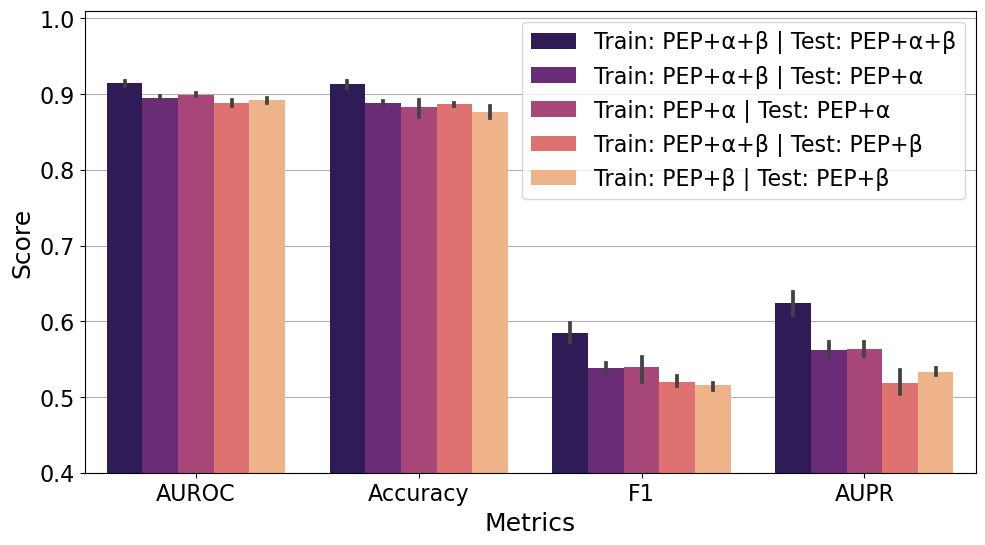

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', axisbelow=True)

results = []

for i in tqdm(range(5)):
    for predictions_file in predictions_files:
        prediction_df = predictions_file[1][i]
        if f'prediction_{i}' in prediction_df.columns:
            scores_df = get_scores(
                y_true=prediction_df['sign'].to_numpy(), 
                y_prob=prediction_df[f'prediction_{i}'].to_numpy(),
                y_pred=prediction_df[f'prediction_{i}'].to_numpy().round(),
            )
            scores_df['Model'] = predictions_file[0]
            results.append(scores_df)
        
results_df = pd.concat(results).rename(columns={'metrics': 'Metrics', 'score': 'Score'})

plt.rcParams['figure.figsize'] = [11.5, 6]
ax = sns.barplot(
    x="Metrics",
    y="Score", 
    hue="Model", 
    data=results_df,
    palette=sns.color_palette("magma", len(predictions_files))
)
# ax.set_title('')
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='best')
legend = plt.legend(frameon = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
ax.grid(axis='y')
ax.set_ylim([0.4, 1.01])

plt.savefig(os.path.join(FIGURES_BASE, "missing-modalities.svg"), format='svg', dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(FIGURES_BASE, "missing-modalities.png"), format='png', dpi=300, bbox_inches='tight')